In [7]:
import pandas_datareader.data as web
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [8]:
country_code = {'US': 'US',
                      'Germany': 'DE',
                      'Japan': 'JP',
                      'UK': 'GB',
                      'France': 'FR'}


item_code = {'M3_rate': 'IR3TIB01__M156N',
             'CPI': 'CPALTT01__M659N'}

In [9]:
# Read all available data for future use
start = datetime.datetime(1950, 1, 1)
end = datetime.datetime(2024, 1, 1)

# Create a dictionary of item codes and country names
M3_item_codes = {item_code['M3_rate'].replace(
                  '__', country_code[country]): country
                  for country in country_code.keys()}

CPI_codes = {item_code['CPI'].replace(
             '__', country_code[country]): country 
             for country in country_code.keys()}

# Read data from FRED
M3_rate_df = web.DataReader(M3_item_codes.keys(), 'fred', start, end)
CPI_df = web.DataReader(CPI_codes.keys(), 'fred', start, end)

# Rename columns
M3_rate_df.rename(columns=M3_item_codes, 
                           inplace=True)

CPI_df.rename(columns=CPI_codes, 
              inplace=True)

# Save data in case API fails
M3_rate_df.to_csv('3-Month_rate.csv')
CPI_df.to_csv('CPI.csv')

In [10]:
M3_rate_df = pd.read_csv('3-Month_rate.csv', parse_dates=True)
CPI_df = pd.read_csv('CPI.csv', parse_dates=True)

M3_rate_df.set_index('DATE', inplace=True)
CPI_df.set_index('DATE', inplace=True)

# shift -2 of rolling average to align with the current month
cpi_rolling_avg = CPI_df.rolling(window=3).mean().shift(-2)

real_df = M3_rate_df.join(cpi_rolling_avg, lsuffix='_rate', rsuffix='_cpi_avg')

# Compute real interest rate
for country in country_code.keys():
    real_df[f'{country}_real_interest'] = (real_df[f'{country}_rate'] 
                                          - real_df[f'{country}_cpi_avg'])
    

real_df.filter(like='_real_interest')


,US_real_interest,Germany_real_interest,Japan_real_interest,UK_real_interest,France_real_interest
DATE,,,,,
1960-01-01,NaN,2.422016,NaN,NaN,NaN
1960-02-01,NaN,2.532016,NaN,NaN,NaN
1960-03-01,NaN,2.481318,NaN,NaN,NaN
1960-04-01,NaN,2.366344,NaN,NaN,NaN
1960-05-01,NaN,2.712611,NaN,NaN,NaN
...,...,...,...,...,...
2023-06-01,1.949310,-2.691753,NaN,-1.576667,-1.023834
2023-07-01,1.835803,-1.939207,NaN,-0.843333,-1.009568
2023-08-01,NaN,-1.038554,NaN,NaN,NaN


In [11]:
def generate_historical_plot(real_df, start, title, end=-1):

    if not isinstance(real_df.index, pd.DatetimeIndex):
        real_df.index = pd.to_datetime(real_df.index)

    if end == -1:
        end = real_df.index[-1]

    # Filter the dataframe to the desired time period
    filtered_df = real_df.loc[start:end]

    adjusted_df = filtered_df.copy()
    adjusted_df['Month_Year'] = adjusted_df.index.strftime('%b %Y')

    plt.figure(figsize=(9, 8), dpi=400)

    # Plotting real interest rates
    for country in ['US', 'Germany', 'Japan', 'UK', 'France']:
        plt.plot(adjusted_df['Month_Year'], adjusted_df[f'{country}_real_interest'], label=country, lw=2)

    # Adding a horizontal line at 0
    plt.axhline(0, color='gray')

    # Customizing the plot
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False) 
    plt.xticks(rotation=45)
    x_ticks = np.linspace(start=0, stop=len(adjusted_df['Month_Year']) - 1, num=5, dtype=int)
    plt.xticks(ticks=adjusted_df['Month_Year'].iloc[x_ticks], labels=adjusted_df['Month_Year'].iloc[x_ticks])
    plt.box(False)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

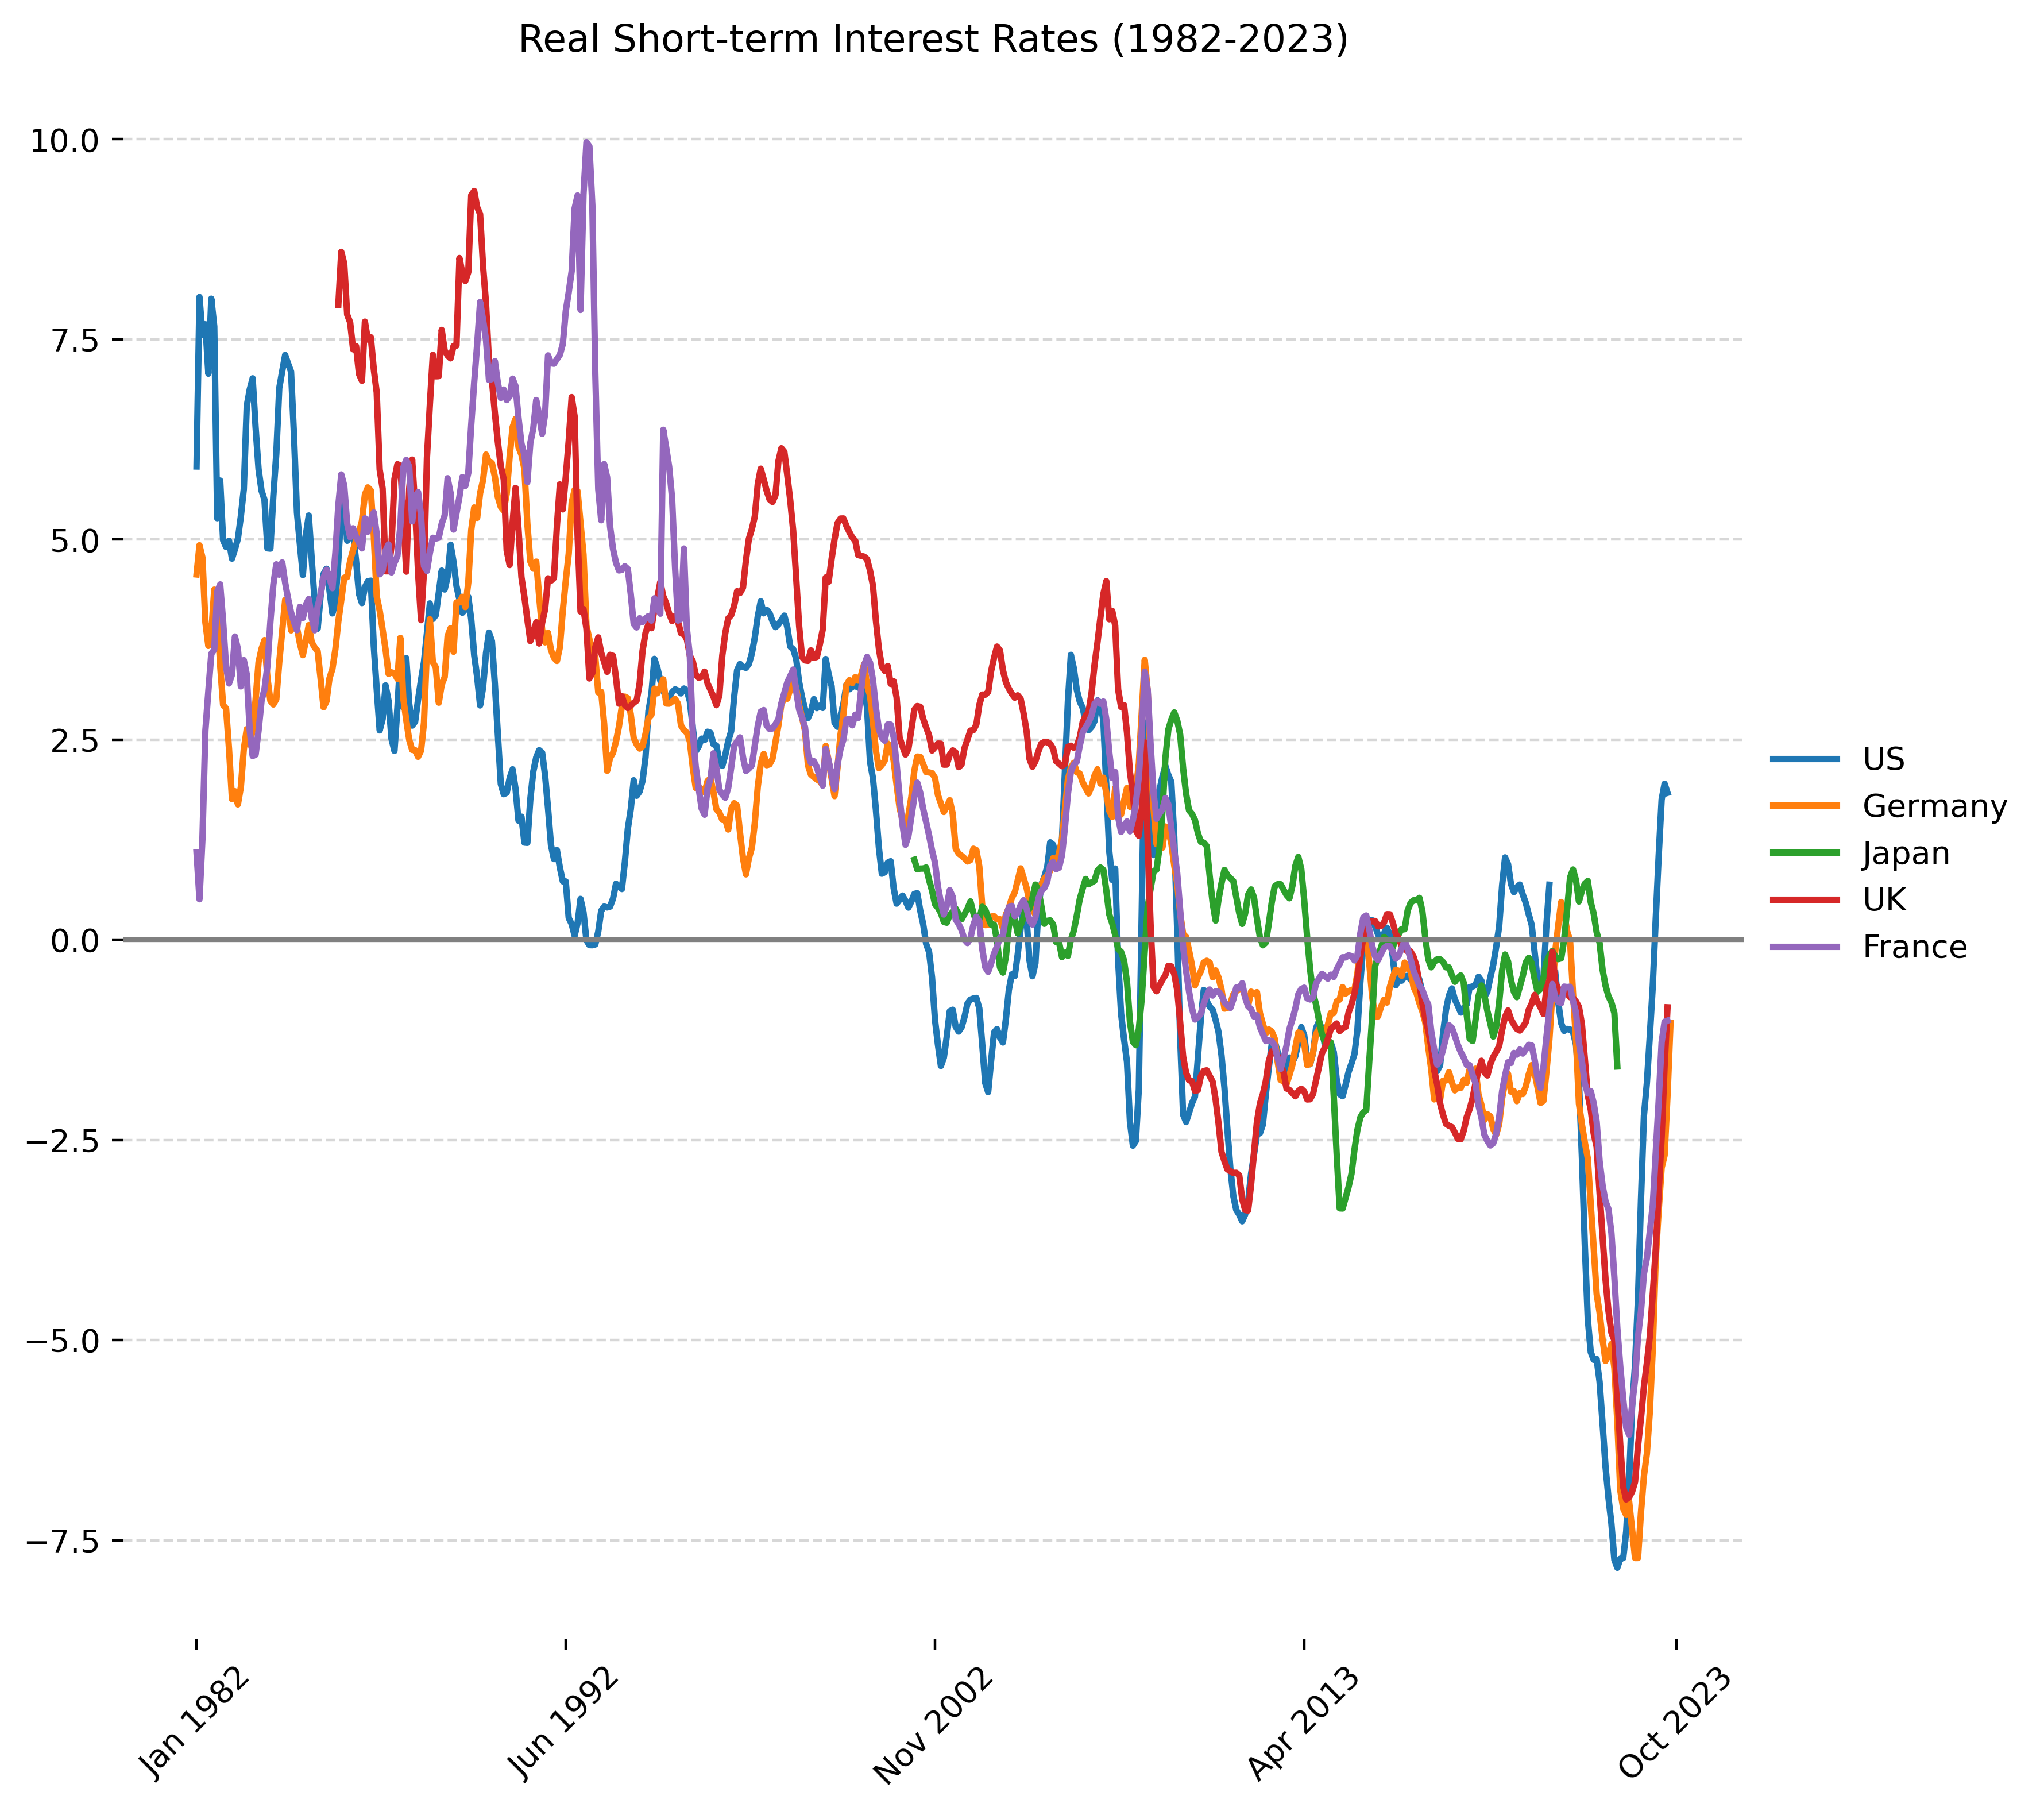

In [12]:
generate_historical_plot(real_df, '1982-01-01', 'Real Short-term Interest Rates (1982-2023)')